## Causal Discovery from multiple contexts and regimes with ``SpaceTime``
 
SpaceTime discovers graphical models (window causal graphs) from non-stationary time series datasets with regime changes.  

Mameche, S, Cornanguer, L, Ninad, U & Vreeken, J. [SpaceTime: Causal Discovery from Non-Stationary Time Series](https://eda.rg.cispa.io/prj/spacetime/).

### 1. Structural Causal Process with Contexts and Regimes



In [1]:
import logging
import warnings

import numpy as np
from matplotlib import pyplot as plt

from exp.utils.gen_timeseries import gen_timeseries
from st.spacetime import SpaceTime

import exp.utils.plot_timeseries as stp
from tigramite.toymodels import structural_causal_processes as toys
import tigramite.data_processing as pp
import tigramite.plotting as tp


Detecting 1 CUDA device(s).


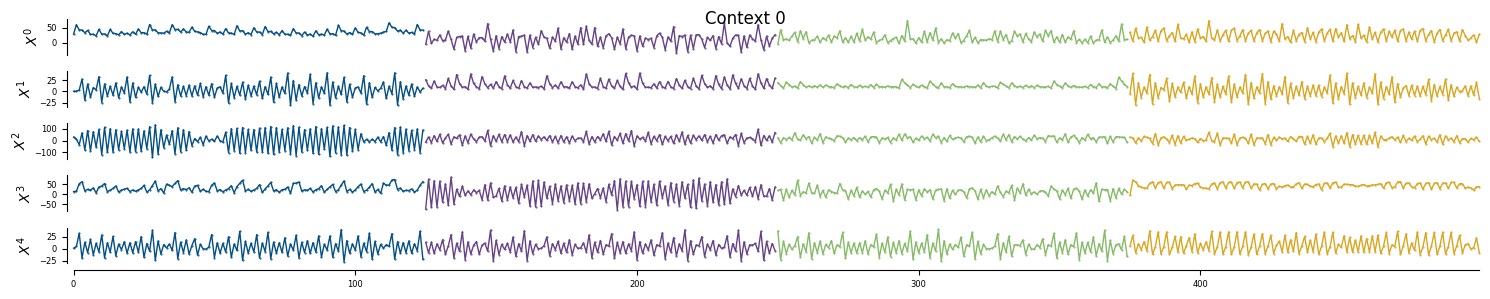

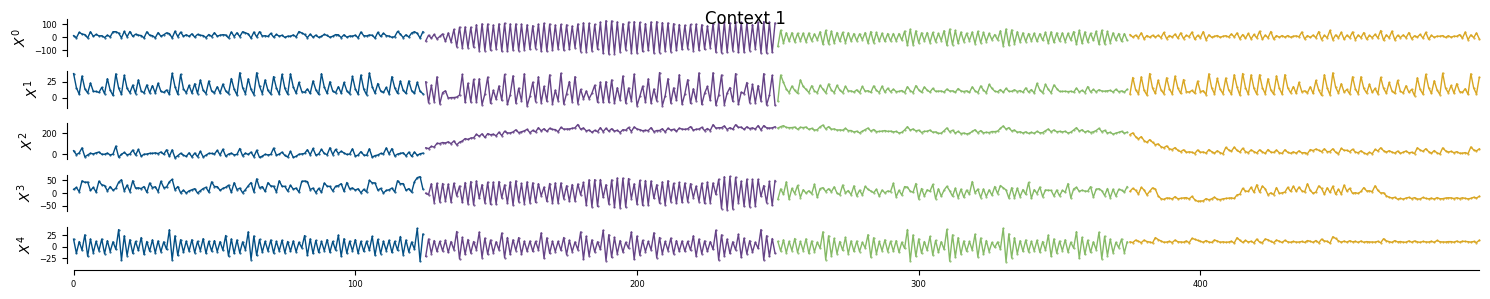

In [5]:
logging.basicConfig()
lg = logging.getLogger("EXAMPLE")
lg.setLevel("INFO")

# DATA  
true_tau_max = 1
true_min_dur = 30
hat_tau_max = 1
hat_min_dur = 20
seed = 42 
np.random.seed(seed)

params = {'C': 2, 'R': 4, 'CPS': 3, 'T': 500, 'D': 1, 'N': 5, 'I': 0.5}
data, truths = gen_timeseries(true_tau_max, true_min_dur, lg=lg, seed=seed, **params)
 
stp.plot_timeseries_regimes_contexts(data, truths.regimes_partition)

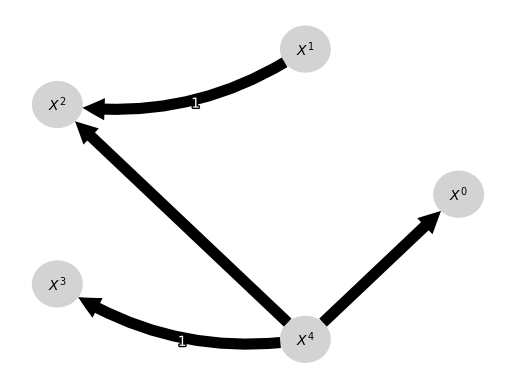

In [13]:
gt_graph = toys.links_to_graph(truths.true_links, tau_max=true_tau_max+1)
var_names = [rf'$X^{i}$' for i in range(params['N'])]
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

### 2. SPACETIME: Causal Discovery, Changepoint Detection, and partitioning

#### 2.1. Causal Discovery

In [26]:
from st.sttypes import MethodType
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    method = MethodType.ST_GP_REGIMES
    st_known_cps = SpaceTime(hat_tau_max, hat_min_dur, method_type=method, truths=truths, logger=lg, verbosity=2)
    st_known_cps.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime ***
INFO:EXAMPLE:Interleaving Iteration 1/max. 1*
INFO:EXAMPLE:	Initialise DAG search:  use true regimes [(1, 125), (126, 250), (251, 375), (376, 500)] vs. true regimes [(2, 125), (127, 250), (252, 375), (377, 500)] , taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 0) -> 3: s=255.36	[caus-diff-lg]
INFO:EXAMPLE:	Adding edge (4, 0) -> 0: s=147.17	[caus]
INFO:EXAMPLE:	Adding edge (4, 0) -> 2: s=129.54	[caus]
INFO:EXAMPLE:	Adding edge (1, 1) -> 2: s=54.91	[caus]
INFO:EXAMPLE:	Adding edge (1, 0) -> 2: s=19.01	[caus-diff-lg]
INFO:EXAMPLE:	Adding edge (4, 1) -> 3: s=84.72	[caus]
INFO:EXAMPLE:Forward: 81.27s 
INFO:EXAMPLE:Phase 2: Backward
INFO:EXAMPLE:Backward: 17.52s 
INFO:EXAMPLE:DAG search result:4->0, 4->3, 4->2, 1->2
INFO:EXAMPLE:DAG search converged!


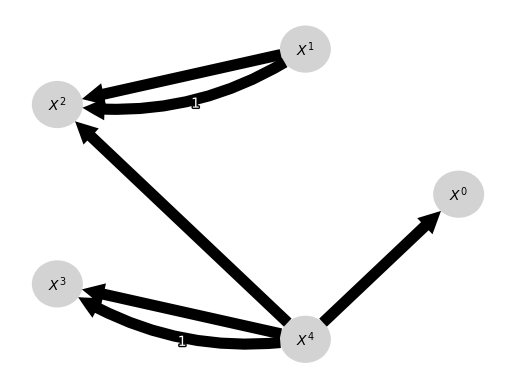

In [28]:
found_links = st_known_cps.result.cur_links[0]
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

#### 2.2. CPS Detection 

In [29]:
from st.sttypes import MethodType
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    method = MethodType.ST_GP_DAG
    st_known_dag = SpaceTime(hat_tau_max, hat_min_dur, method_type=method, truths=truths, logger=lg, verbosity=2)
    st_known_dag.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime ***
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:	> CPS Result (G*: given, initialization: noparents): [(0, 123, 0.0), (123, 127, 1.0), (250, 130, 2.0), (380, 120, 3.0)]
INFO:EXAMPLE:	> CPS True: [(0, 125, 0), (125, 125, 3), (250, 125, 2), (375, 125, 1)]
INFO:EXAMPLE:	> CPS F1: 0.67 prec: 0.67, recall: 0.67, ari: 0.963, nmi: 0.954 (max. tol. 3)
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:CPS search converged!
INFO:EXAMPLE:	> CPS Result (G*: given, initialization: noparents): [(0, 123, 0.0), (123, 127, 1.0), (250, 130, 2.0), (380, 120, 3.0)]
INFO:EXAMPLE:	> CPS True: [(0, 125, 0), (125, 125, 3), (250, 125, 2), (375, 125, 1)]
INFO:EXAMPLE:	> CPS F1: 0.67 prec: 0.67, recall: 0.67, ari: 0.963, nmi: 0.954 (max. tol. 3)


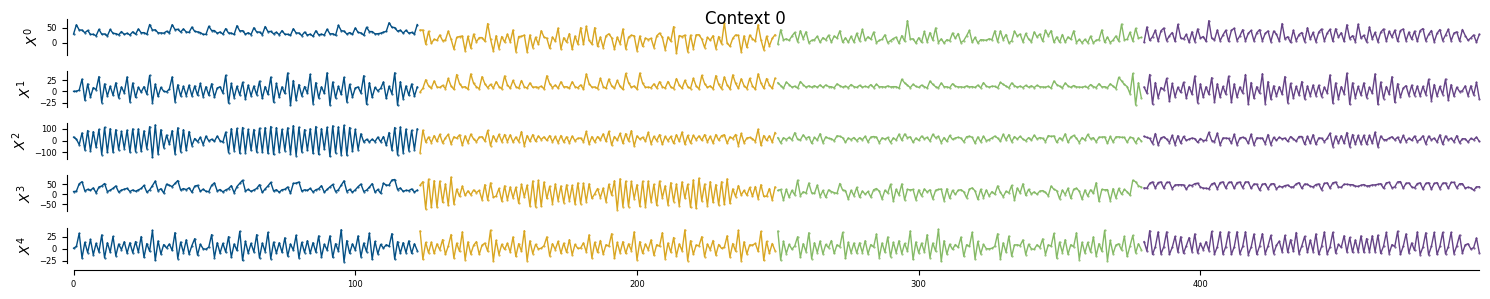

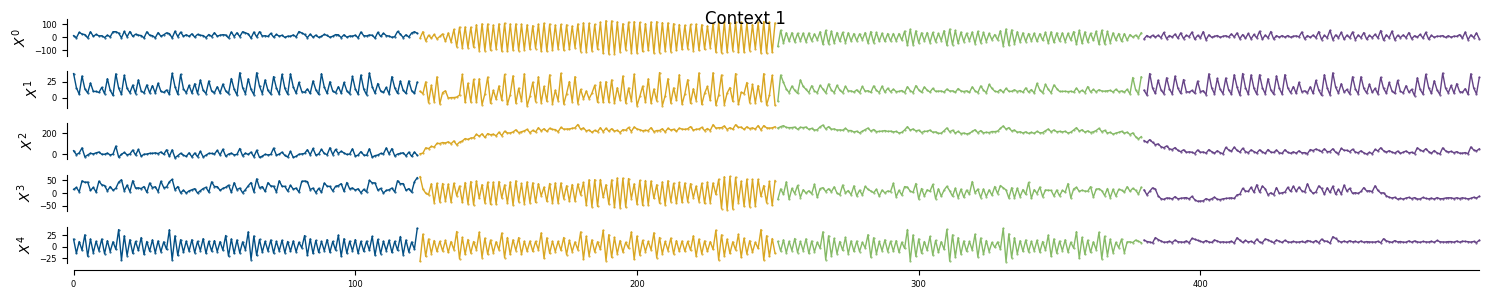

In [30]:
found_regimes = st_known_dag.result.cur_regimes

stp.plot_timeseries_regimes_contexts(data, found_regimes)

#### 2.3. Interleaving (and hybrid) C.D. and CPS Discovery

In [31]:
#### 2.3. Full method
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    optargs = {
    'hybrid_cps_dag_discovery': False    
}
    st = SpaceTime(hat_tau_max, hat_min_dur, truths=truths, logger=lg, verbosity=1, **optargs)
    st.run(data.datasets)

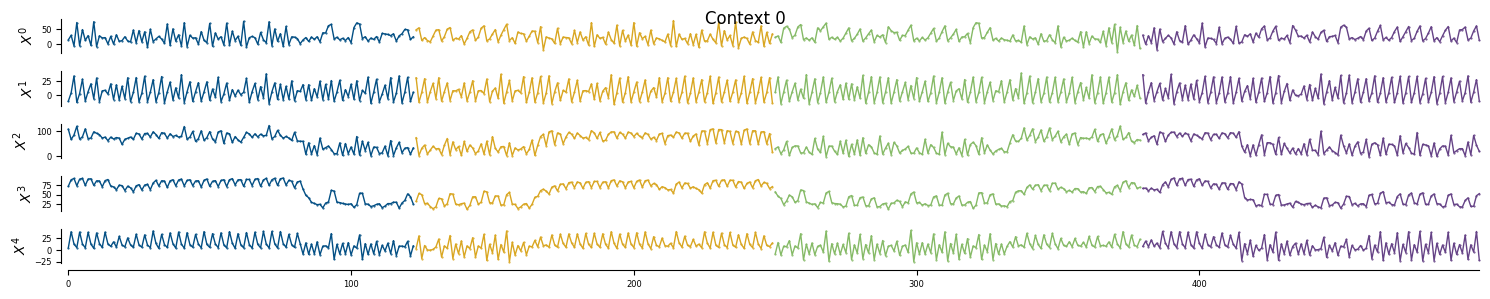

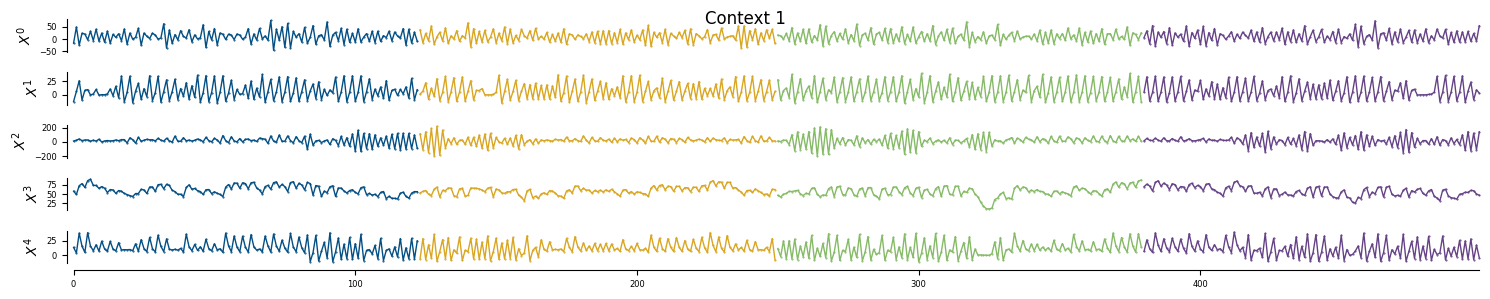

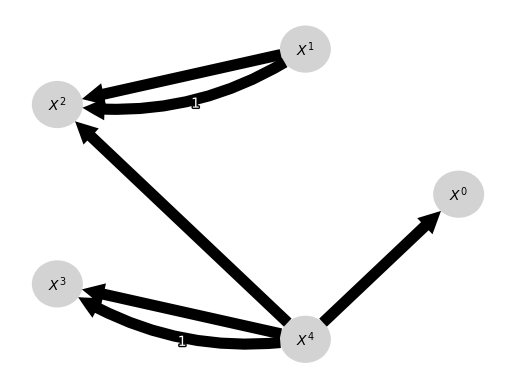

In [35]:
st.get_metrics()
stp.plot_timeseries_regimes_contexts(data, st.result.cur_regimes)
found_links = st_known_cps.result.cur_links[0] 
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

#### 2.4. Partitioning


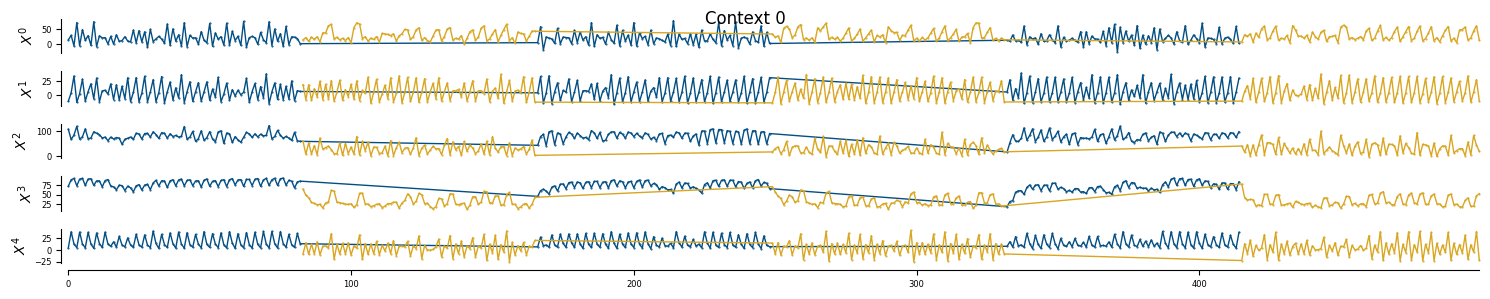

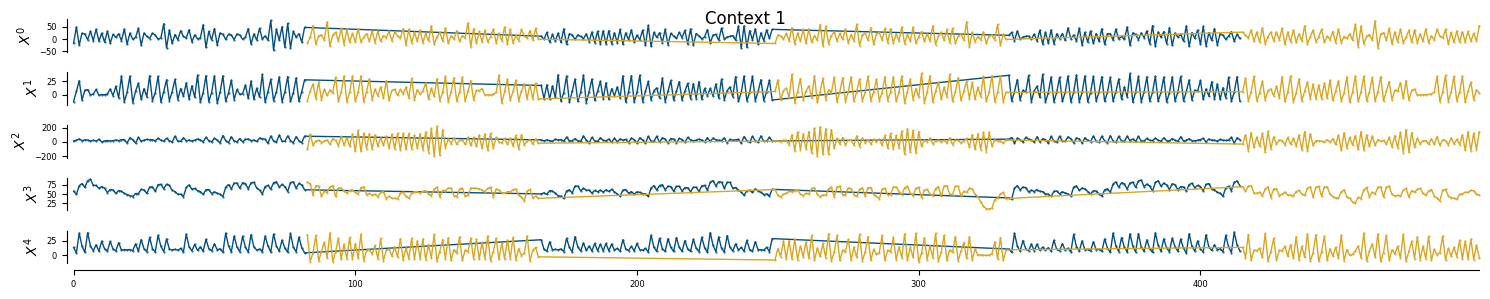

In [33]:
#### 2.4. Partitioning

# Generate a dataset with repeating regimes - 2 regimes at 5 changepoints
params = {'C': 2, 'R': 2, 'CPS': 5, 'T': 500, 'D': 1, 'N': 5, 'I': 0.5}
data, truths = gen_timeseries(true_tau_max, true_min_dur, lg=lg, seed=seed, **params)
 
stp.plot_timeseries_regimes_contexts(data, truths.regimes_partition) 

In [36]:
# run spacetime
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    optargs = {
    'hybrid_cps_dag_discovery': False    
}
    st = SpaceTime(hat_tau_max, hat_min_dur, truths=truths, logger=lg, verbosity=1, **optargs)
    st.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime ***
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 79, 0.0), (79, 88, 1.0), (167, 82, 0.0), (249, 85, 1.0), (334, 82, 0.0), (416, 84, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 83, 0), (83, 83, 1), (166, 83, 0), (249, 83, 1), (332, 83, 0), (415, 85, 1)]
INFO:EXAMPLE:	> CPS F1: 0.8 prec: 0.8, recall: 0.8, ari: 0.937, nmi: 0.889 (max. tol. 3)
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:	Initialise DAG search:  use current regimes [(1, 79), (80, 167), (168, 249), (250, 334), (335, 416), (417, 500)] vs. true regimes [(2, 83), (85, 166), (168, 249), (251, 332), (334, 415), (417, 500)] , taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 0) -> 3: s=617.79	[caus-diff-lg]
INFO:EXAMPLE:	Adding edge (1, 0) -> 2: s=220.67	[caus-diff-lg]
INFO:EXAMPLE:	Adding edge (4, 1) -> 0: s=132.83	[caus-diff-lg]


SpaceTime discovers the alternating regimes correctly, as shown below. 

INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 79, 0.0), (79, 88, 1.0), (167, 82, 0.0), (249, 85, 1.0), (334, 82, 0.0), (416, 84, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 83, 0), (83, 83, 1), (166, 83, 0), (249, 83, 1), (332, 83, 0), (415, 85, 1)]
INFO:EXAMPLE:	> CPS F1: 0.8 prec: 0.8, recall: 0.8, ari: 0.937, nmi: 0.889 (max. tol. 3)


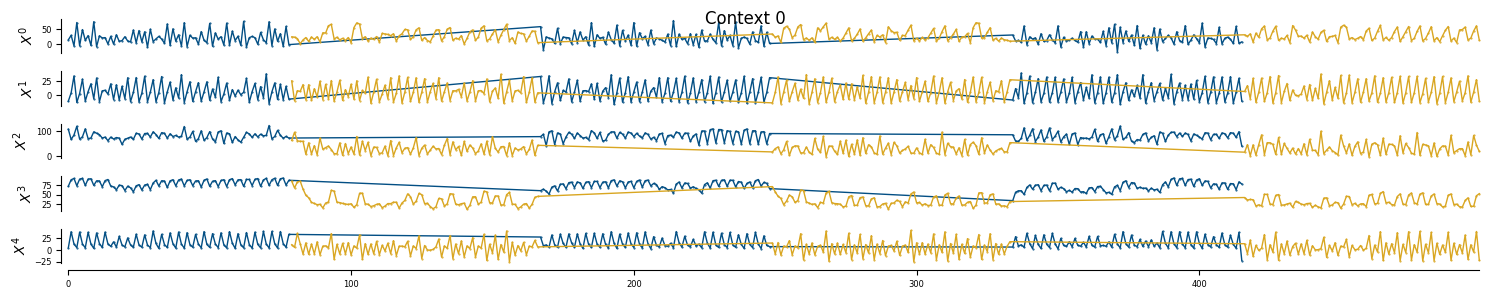

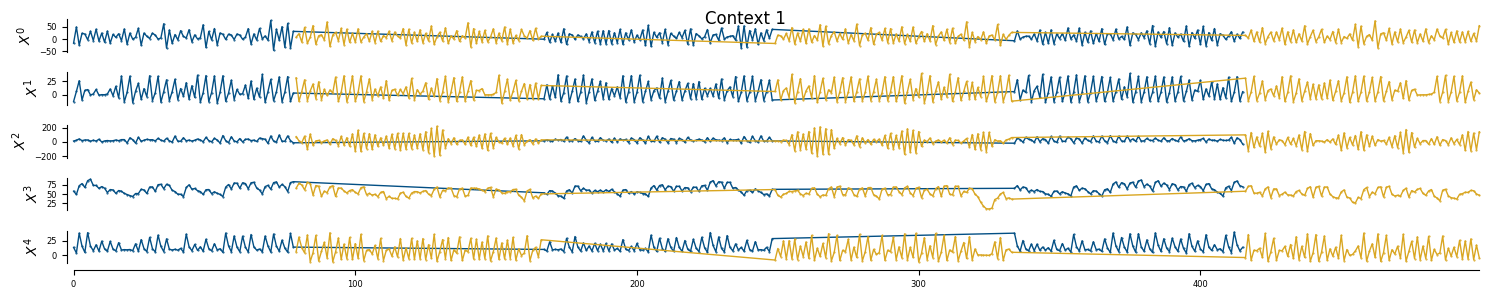

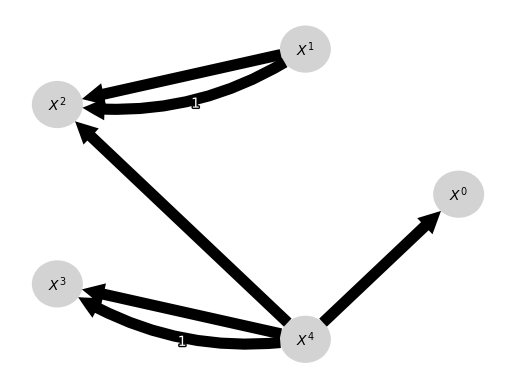

In [37]:
st.get_metrics()
stp.plot_timeseries_regimes_contexts(data, st.result.cur_regimes)
found_links = st_known_cps.result.cur_links[0] 
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()